In [121]:
import numpy as np

# 假设有 3 台机器和 3 个操作
m = 3  # 机器数量
N = 2  # 表示机器的二进制 (0, 1)
n = 2  # 操作数量
l = 1  # 用于表示 C_max 的二进制位数

# 处理时间矩阵 (例如)
p = np.array([[3, 1, 3], [2, 3, 1]])

b = np.array([[0, 0], [1, 0], [0, 1]])
# 非法数组(用于表示机器数)(1, 1)
bw = np.array([[1, 1]])
# 常数
K1 = 10
P = 10
# print(len(bw))
# 量子比特数量
num_qubits = n * N + l

In [122]:
def append_multi_rzz_term(qc, qubits, gamma):
    """
    实现多体 Z 相互作用项 e^{-i \gamma Z_1 Z_2 \dots Z_k}.
    """
    if len(qubits) == 0:
        return
    if len(qubits) == 1:
        qc.rz(2 * gamma, qubits[0])
        return

    # 链式 CNOT 到最后一个量子比特
    for q in qubits[:-1]:
        qc.cx(q, qubits[-1])

    # 应用 RZ 门
    qc.rz(2 * gamma, qubits[-1])

    # 恢复链式 CNOT
    for q in reversed(qubits[:-1]):
        qc.cx(q, qubits[-1])

In [123]:
def append__zz_term(qc, qubit1, qubit2, gamma):
    qc.cx(qubit1, qubit2)
    qc.rz(gamma, qubit2)
    qc.cx(qubit1, qubit2)


def append__z_term(qc, qubit, gamma):
    qc.rz(gamma, qubit)


def append__mixer_term(qc, qubit, beta):
    qc.rx(2 * beta, qubit)

In [124]:
def get_cost_circuit1(gamma, qc):
    for h in range(l):
        coef = -0.5 * 2 ** h  # 或 -2**(h-1)
        append__z_term(qc, N * n + h, gamma * coef)  # RZ(2 * (-2^(h-1)) * gamma)
    return qc

\begin{align}K_{1} \sum_{j\in W} \sum_{i=0}^{n}\prod_{k=0}^{N}\left(\frac{1}2+\left(\frac{1}2-b_{j k}\right)Z_{ik}\right)\end{align}

In [125]:
import itertools


def get_cost_circuit2(gamma, qc):
    if len(bw) == 0:
        return qc
    all_combinations = list(
        itertools.chain(*([[]], *(itertools.combinations(range(N), r) for r in range(1, N + 1)))))  # 包含空集
    for j in range(len(bw)):
        for i in range(n):
            for qubit_indices in all_combinations:
                constant = K1 / (2 ** N)  # 初始系数包含 K1
                qubits_index = np.array([], dtype=int)
                for k in range(N):
                    if k in qubit_indices:
                        constant *= (1 - 2 * bw[j, k])
                        qubits_index = np.append(qubits_index, i * N + k)
                # 空集项不添加量子门，仅影响全局相位（可忽略）
                if len(qubits_index) > 0:
                    append_multi_rzz_term(qc, qubits_index, constant * gamma)
    return qc


\begin{align}\sum_{j=0}^{m-1}\sum_{i=0}^{n-1} \sum_{i^{\prime}=0}^{n-1}\left(\prod_{k=0}^{N-1}\frac{1}{2}\left(1+\left(1-2b_{j k}\right) Z_{i k}\right)\right) p_{i j}\left(\prod_{k^{\prime}=0}^{N-1}\frac{1}{2}\left(1+\left(1-2b_{j k}\right) Z_{i^{\prime} k^{\prime}}\right)\right) p_{i^{\prime} j}\end{align}
\begin{align}-2 \sum_{j=0}^{m-1} \sum_{i=0}^{n-1} \sum_{h=0}^{l-1} \left(\prod_{k=0}^{N-1}\frac{1}{2}\left(1+\left(1-2b_{j k}\right) Z_{i k}\right)\right) p_{i j} \cdot 2^{h-1}\left(1-Z_h\right)\end{align}
\begin{align}\sum_{j=0}^{m-1}\sum_{h=0}^{l-1} \sum_{h^{\prime}=0}^{l-1} 2^{h-1} 2^{h^{\prime}-1}\left(1-Z_h-Z_{h^{\prime}}+Z_h Z_{h^{\prime}}\right)\end{align}

In [126]:
from collections import Counter
import itertools


def get_cost_circuit3(gamma, qc):
    all_combinations = list(itertools.chain(*([[]], *(itertools.combinations(range(N), r) for r in range(1, N + 1)))))

    for j in range(m):
        # C_j^2
        for i in range(n):
            for i_prime in range(n):
                for S_i in all_combinations:
                    for S_i_prime in all_combinations:
                        constant = P * p[i, j] * p[i_prime, j] / (2 ** (2 * N))
                        qubits_index = []
                        for k in S_i:
                            constant *= (1 - 2 * b[j, k])
                            qubits_index.append(i * N + k)
                        for k in S_i_prime:
                            constant *= (1 - 2 * b[j, k])
                            qubits_index.append(i_prime * N + k)
                        count = Counter(qubits_index)
                        qubits_final = [x for x in count if count[x] % 2 != 0]
                        append_multi_rzz_term(qc, qubits_final, gamma * constant)

        # -2 C_j C_max
        for i in range(n):
            constant = P * p[i, j] / (2 ** N)
            for S_i in all_combinations:
                coef = constant
                qubits_S = []
                for k in S_i:
                    coef *= (1 - 2 * b[j, k])
                    qubits_S.append(i * N + k)
                append_multi_rzz_term(qc, qubits_S, -2 * gamma * coef * (2 ** l - 1))
                for h in range(l):
                    qubits_combined = qubits_S + [n * N + h]
                    append_multi_rzz_term(qc, qubits_combined, 2 * gamma * coef * 2 ** h)

        # C_max^2
        for h in range(l):
            coef = -0.5 * P * (2 ** l - 1) * 2 ** h
            append__z_term(qc, n * N + h, gamma * coef)
            for h_prime in range(l):
                if h != h_prime:
                    coef = 0.25 * P * 2 ** h * 2 ** h_prime
                    append__zz_term(qc, n * N + h, n * N + h_prime, gamma * coef)

    return qc



In [132]:
def get_mixer_circuit(beta, qc):
    for i in range(num_qubits):
        append__mixer_term(qc, i, beta)
    return qc

# def get_mixer_circuit(beta, qc):
#     for i in range(n * N):  # 只作用于 s_{ik} 比特
#         append__mixer_term(qc, i, beta)  # 调整为 RX(-2β)
#     return qc

In [133]:
def invert_counts(s):
    return s[::-1]

In [134]:
from qiskit import Aer, QuantumCircuit, execute


# 定义成本函数
def cost_function(params):
    beta, gamma = params[:len(params) // 2], params[len(params) // 2:]
    num_qubits = n * N + l
    qc = QuantumCircuit(num_qubits, num_qubits)
    qc.h(range(num_qubits))
    # print(qc)

    length = len(params)
    for i in range(int(length / 2)):
        get_cost_circuit1(gamma[i], qc)
        get_cost_circuit2(gamma[i], qc)
        get_cost_circuit3(gamma[i], qc)
        get_mixer_circuit(beta[i], qc)
    # 模拟电路
    # 添加测量指令
    qc.measure(range(num_qubits), range(num_qubits))
    backend = Aer.get_backend('qasm_simulator')
    result = execute(qc, backend, seed_simulator=10, shots=10000).result()
    counts = result.get_counts(qc)
    # 计算期望值
    expectation = 0
    for bitstring, count in counts.items():
        bitstring = invert_counts(bitstring)
        prob = count / 10000
        z_h = np.array([int(bit) for bit in bitstring[(n * N):]])
        s_ik = np.array([int(bit) for bit in bitstring[:(n * N)]]).reshape(n, N)
        E1 = np.sum([2 ** h * z for h, z in enumerate(z_h)])
        E2 = 0
        for j in range(len(bw)):
            for i in range(n):
                constant = 1
                for k in range(N):
                    constant = constant * (1 - (s_ik[i, k] - bw[j, k]) ** 2)
                E2 += constant
        E2 = K1 * E2
        E3 = 0
        for j in range(m):
            constant1 = 0
            for i in range(n):
                constant2 = 1
                for k in range(N):
                    constant2 = constant2 * (1 - (s_ik[i, k] - b[j, k]) ** 2)
                constant1 += p[i, j] * constant2
            constant3 = 0
            for h in range(l):
                constant3 += 2 ** h * z_h[h]
            constant = max(0, constant1 - constant3)
            E3 += P * (constant) ** 2

        # alpha_s = np.max([0, np.sum(x_ij * p) - np.sum([2 ** h * z for h, z in enumerate(z_h)])])

        E = E1 + E2 + E3

        expectation += E * prob

    return expectation, counts

In [135]:
from qiskit_algorithms.optimizers import COBYLA


# 优化 QAOA 参数
def optimize_qaoa(params):
    def objective(params):
        expectation, _ = cost_function(params)

        return expectation

    optimizer = COBYLA(rhobeg=1.5, tol=1e-8)
    # params = np.random.rand(2 * p_max) * 2 * np.pi
    result = optimizer.minimize(fun=objective, x0=params)

    return result

In [136]:
import time

# 运行优化
startTime = time.time()
ansatz_final = object()
init_point = np.array([])
counts = {}
min_energy = 0
final_result = object()
for p1 in range(1, 4):
    min_energy = 10000
    for k in range(10):
        print('第：', p1, '层', ' ', '第', k, '个参数')
        init_point_temp = init_point
        beta_p = np.random.uniform(0, np.pi)
        gamma_p = np.random.uniform(0, 2 * np.pi)
        if k > 0:
            init_point_temp = np.delete(init_point_temp, 2 * p1 - 1)
            init_point_temp = np.delete(init_point_temp, p1 - 1)
        init_point_temp = np.insert(init_point_temp, p1 - 1, beta_p)
        init_point_temp = np.insert(init_point_temp, 2 * p1 - 1, gamma_p)
        result = optimize_qaoa(init_point_temp)

        # print(result.x)
        optimal_params = result.x

        # 计算最终的能量
        energy, counts_temp = cost_function(result.x)
        if min_energy > energy:
            min_energy = energy
            init_point = optimal_params
            counts = counts_temp
            final_result = result
endTime = time.time()

第： 1 层   第 0 个参数
第： 1 层   第 1 个参数
第： 1 层   第 2 个参数
第： 1 层   第 3 个参数
第： 1 层   第 4 个参数
第： 1 层   第 5 个参数
第： 1 层   第 6 个参数
第： 1 层   第 7 个参数
第： 1 层   第 8 个参数
第： 1 层   第 9 个参数
第： 2 层   第 0 个参数
第： 2 层   第 1 个参数
第： 2 层   第 2 个参数
第： 2 层   第 3 个参数
第： 2 层   第 4 个参数
第： 2 层   第 5 个参数
第： 2 层   第 6 个参数
第： 2 层   第 7 个参数
第： 2 层   第 8 个参数
第： 2 层   第 9 个参数
第： 3 层   第 0 个参数
第： 3 层   第 1 个参数
第： 3 层   第 2 个参数
第： 3 层   第 3 个参数
第： 3 层   第 4 个参数
第： 3 层   第 5 个参数
第： 3 层   第 6 个参数
第： 3 层   第 7 个参数
第： 3 层   第 8 个参数
第： 3 层   第 9 个参数


优化时间： 291.0195734500885
Optimal parameters: [5.76137355 1.0838909  0.9463345  2.58852719 4.96337366 3.04397192]
Optimal value: 41.38550000000001
Final expectation value: 41.38550000000001
Final measurement counts: {'10110': 1537, '00011': 1267, '11001': 927, '11110': 718, '11111': 711, '10001': 588, '10011': 503, '00101': 492, '01001': 408, '00111': 291, '10111': 254, '01011': 234, '11101': 225, '11100': 222, '10000': 212, '11000': 201, '11010': 159, '10100': 157, '01101': 148, '00001': 139, '10010': 132, '01110': 110}


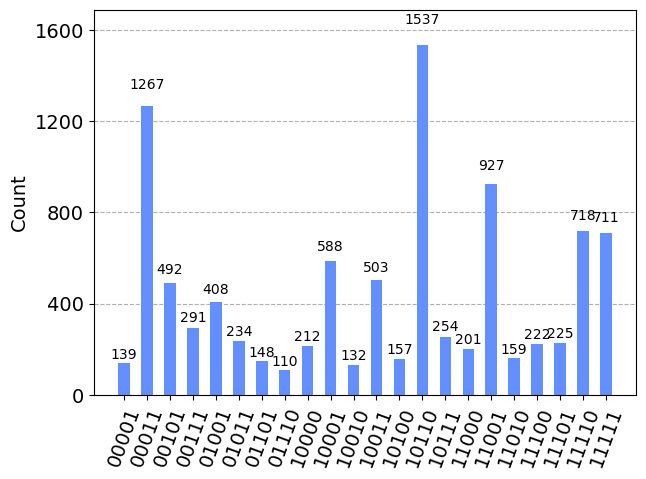

In [137]:
import warnings
from qiskit.visualization import plot_histogram

# 忽略弃用警告
warnings.filterwarnings("ignore", category=DeprecationWarning)
# 输出结果
print("优化时间：", endTime - startTime)
print("Optimal parameters:", final_result.x)
print("Optimal value:", final_result.fun)
# 使用最优参数运行量子电路并输出测量结果
final_expectation, final_counts = cost_function(final_result.x)
sorted_dict = {item[0][::-1]: item[1] for item in sorted(final_counts.items(), key=lambda item: item[1], reverse=True)}
# 过滤掉计数小于 100 的结果
filtered_dict = {key: value for key, value in sorted_dict.items() if value >= 100}
print("Final expectation value:", final_expectation)
print("Final measurement counts:", filtered_dict)
plot_histogram(filtered_dict)

In [79]:
# 计算期望值
expectation = 0
for bitstring, count in sorted_dict.items():
    bitstring = invert_counts(bitstring)
    prob = count / 10000
    z_h = np.array([int(bit) for bit in bitstring[n * N:]])
    s_ik = np.array([int(bit) for bit in bitstring[:n * N]]).reshape(n, N)
    E1 = np.sum([2 ** h * z for h, z in enumerate(z_h)])
    E2 = 0
    for j in range(len(bw)):  # 假设 bw 定义为 W
        for i in range(n):
            constant = 1
            for k in range(N):
                constant *= (1 - (s_ik[i, k] - bw[j, k]) ** 2)
            E2 += constant
    E2 = K1 * E2
    E3 = 0
    for j in range(m):
        C_j = 0
        for i in range(n):
            constant = 1
            for k in range(N):
                constant *= (1 - (s_ik[i, k] - b[j, k]) ** 2)
            C_j += p[i, j] * constant
        C_max = np.sum([2 ** h * z_h[h] for h in range(l)])
        E3 += P * (C_j - C_max) ** 2
    E = E1 + E2 + E3
    expectation += E * prob
print(expectation)

667.0323999999999


In [108]:
expectation = 0
bitstring = "10010"
z_h = np.array([int(bit) for bit in bitstring[(n * N):]])
s_ik = np.array([int(bit) for bit in bitstring[:(n * N)]]).reshape(n, N)
E1 = np.sum([2 ** h * z for h, z in enumerate(z_h)])
E2 = 0
for j in range(len(bw)):
    for i in range(n):
        constant = 1
        for k in range(N):
            constant = constant * (1 - (s_ik[i, k] - bw[j, k]) ** 2)
        E2 += constant
E2 = K1 * E2
E3 = 0
for j in range(m):
    constant1 = 0
    # print("机器：", j)
    for i in range(n):
        constant2 = 1
        for k in range(N):
            constant2 = constant2 * (1 - (s_ik[i, k] - b[j, k]) ** 2)
        # print("constant2:", constant2)
        # print("p[i,j]:", p[i,j])
        constant1 += p[i, j] * constant2
    # print("constant1:", constant1)
    constant3 = 0
    for h in range(l):
        constant3 += 2 ** h * z_h[h]
    # print("constant3:", constant3)
    constant = max(0, constant1 - constant3)
    E3 += (constant) ** 2

    # alpha_s = np.max([0, np.sum(x_ij * p) - np.sum([2 ** h * z for h, z in enumerate(z_h)])])

E = E1 + K1 * E2 + P * E3
print(E1)
print(E2)
print(E3)
# print(e1)
# print(e2)

0
0
2
